In [155]:
from datetime import datetime
from datetime import timedelta
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

## GRU Moduel

In [156]:
class GRU:
    """Implementation of a Gated Recurrent Unit (GRU) as described in [1].

    [1] Chung, J., Gulcehre, C., Cho, K., & Bengio, Y. (2014). Empirical evaluation of gated recurrent neural networks on sequence modeling. arXiv preprint arXiv:1412.3555.

    Arguments
    ---------
    input_dimensions: int
        The size of the input vectors (x_t).
    hidden_size: int
        The size of the hidden layer vectors (h_t).
    dtype: obj
        The datatype used for the variables and constants (optional).
    """

    def __init__(self, input_dimensions, hidden_size, dtype=tf.float64):
        self.input_dimensions = input_dimensions
        self.hidden_size = hidden_size

        # Weights for input vectors of shape (input_dimensions, hidden_size)
        self.Wr = tf.Variable(tf.truncated_normal(dtype=dtype, shape=(
            self.input_dimensions, self.hidden_size), mean=0, stddev=0.01), name='Wr')
        self.Wz = tf.Variable(tf.truncated_normal(dtype=dtype, shape=(
            self.input_dimensions, self.hidden_size), mean=0, stddev=0.01), name='Wz')
        self.Wh = tf.Variable(tf.truncated_normal(dtype=dtype, shape=(
            self.input_dimensions, self.hidden_size), mean=0, stddev=0.01), name='Wh')

        # Weights for hidden vectors of shape (hidden_size, hidden_size)
        self.Ur = tf.Variable(tf.truncated_normal(dtype=dtype, shape=(
            self.hidden_size, self.hidden_size), mean=0, stddev=0.01), name='Ur')
        self.Uz = tf.Variable(tf.truncated_normal(dtype=dtype, shape=(
            self.hidden_size, self.hidden_size), mean=0, stddev=0.01), name='Uz')
        self.Uh = tf.Variable(tf.truncated_normal(dtype=dtype, shape=(
            self.hidden_size, self.hidden_size), mean=0, stddev=0.01), name='Uh')

        # Biases for hidden vectors of shape (hidden_size,)
        self.br = tf.Variable(tf.truncated_normal(dtype=dtype, shape=(
            self.hidden_size,), mean=0, stddev=0.01), name='br')
        self.bz = tf.Variable(tf.truncated_normal(dtype=dtype, shape=(
            self.hidden_size,), mean=0, stddev=0.01), name='bz')
        self.bh = tf.Variable(tf.truncated_normal(dtype=dtype, shape=(
            self.hidden_size,), mean=0, stddev=0.01), name='bh')

        # Define the input layer placeholder
        self.input_layer = tf.placeholder(dtype=tf.float64, shape=(
            None, None, input_dimensions), name='input')

        # Put the time-dimension upfront for the scan operator
        self.x_t = tf.transpose(self.input_layer, [1, 0, 2], name='x_t')

        # A little hack (to obtain the same shape as the input matrix) to define the initial hidden state h_0
        self.h_0 = tf.matmul(self.x_t[0, :, :], tf.zeros(
            dtype=tf.float64, shape=(input_dimensions, hidden_size)), name='h_0')

        # Perform the scan operator
        self.h_t_transposed = tf.scan(
            self.forward_pass, self.x_t, initializer=self.h_0, name='h_t_transposed')

        # Transpose the result back
        self.h_t = tf.transpose(self.h_t_transposed, [1, 0, 2], name='h_t')

    def forward_pass(self, h_tm1, x_t):
        """Perform a forward pass.

        Arguments
        ---------
        h_tm1: np.matrix
            The hidden state at the previous timestep (h_{t-1}).
        x_t: np.matrix
            The input vector.
        """
        # Definitions of z_t and r_t
        z_t = tf.sigmoid(tf.matmul(x_t, self.Wz) +
                         tf.matmul(h_tm1, self.Uz) + self.bz)
        r_t = tf.sigmoid(tf.matmul(x_t, self.Wr) +
                         tf.matmul(h_tm1, self.Ur) + self.br)

        # Definition of h~_t
        h_proposal = tf.tanh(tf.matmul(
            x_t, self.Wh) + tf.matmul(tf.multiply(r_t, h_tm1), self.Uh) + self.bh)

        # Compute the next hidden state
        h_t = tf.multiply(1 - z_t, h_tm1) + tf.multiply(z_t, h_proposal)

        return h_t

## Data Processing

In [157]:
df = pd.read_csv('wrds_top_2000_3mo_lag.dat', sep=' ')
df = df[df['gvkey'] == 133367]
df['year'] = df['year'].map(lambda x: str(x))
df['month'] = df['month'].map(lambda x: str(x))
df['-'] = '-'
df['timestemp'] = df['year'] + df['-'] + df['month']
df['timestemp'] = pd.to_datetime(df['timestemp'])
df = df.set_index('timestemp')
df = df.drop(['active', 'year', 'month', '-', 'date'], axis=1)
df['EBIT'] = df['saleq_ttm'] - df['cogsq_ttm'] - df['xsgaq_ttm']
df['EBIT/EV'] = df['EBIT'] / df['entval']

In [158]:
def trainingSet(df,featureList,freq,trainingLenth):
    x = np.empty((trainingLenth-freq, freq, len(featureList)))
    y = np.empty((trainingLenth-freq, freq, 1))
    for i in range(trainingLenth-freq):
        y[i, :, 0] = df['EBIT/EV'].iloc[i:i+freq].values
        for j in range(len(featureList)):
            x[i, :, j] = list(df[featureList[j]].iloc[i:i+freq].values)
    return x, y

In [159]:
def sampleGenerating(df,featureList,freq,trainingLenth):
    X_train, Y_train = trainingSet(df,featureList,freq,trainingLenth)
    testdf = df[trainingLenth:]
    trainingLenth = len(testdf)
    X_test, Y_test = trainingSet(testdf,featureList,freq,trainingLenth)
    return X_train, Y_train, X_test, Y_test

## Configuration

In [160]:
df.columns

Index(['gvkey', 'gics-sector', 'mom1m', 'mom3m', 'mom6m', 'mom9m', 'mrkcap',
       'entval', 'saleq_ttm', 'cogsq_ttm', 'xsgaq_ttm', 'oiadpq_ttm',
       'niq_ttm', 'cheq_mrq', 'rectq_mrq', 'invtq_mrq', 'acoq_mrq',
       'ppentq_mrq', 'aoq_mrq', 'dlcq_mrq', 'apq_mrq', 'txpq_mrq', 'lcoq_mrq',
       'ltq_mrq', 'seqq_mrq', 'atq_mrq', 'csho_1yr_avg', 'adjusted_price',
       'prccm', 'ajexm', 'EBIT', 'EBIT/EV'],
      dtype='object')

In [161]:
trainingLenth = 29
freq = 5
featureList = ['mom1m','mom3m','cogsq_ttm', 'xsgaq_ttm', 'oiadpq_ttm',
       'niq_ttm', 'cheq_mrq', 'rectq_mrq', 'invtq_mrq', 'acoq_mrq',
       'ppentq_mrq', 'aoq_mrq', 'dlcq_mrq', 'apq_mrq', 'txpq_mrq', 'lcoq_mrq',
       'ltq_mrq', 'seqq_mrq', 'atq_mrq', 'csho_1yr_avg', 'adjusted_price',
       'prccm', 'ajexm']

In [162]:
X_train, Y_train, X_test, Y_test = sampleGenerating(df,featureList,freq,trainingLenth)

In [163]:
batch_size = trainingLenth - freq
time_size = freq
input_dimensions = len(featureList)
hidden_size = 5

## Training and Testing

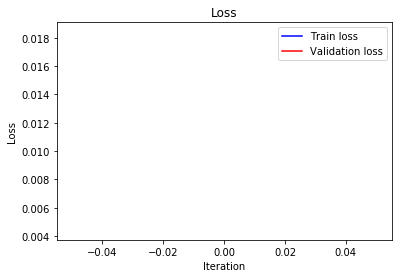

Iteration: 0, train loss: 0.0184, test loss: 0.0044


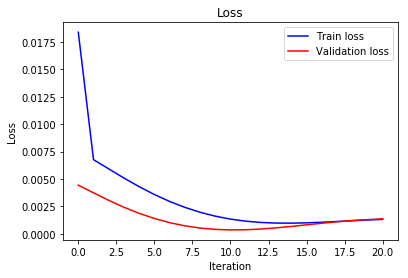

Iteration: 20, train loss: 0.0013, test loss: 0.0014


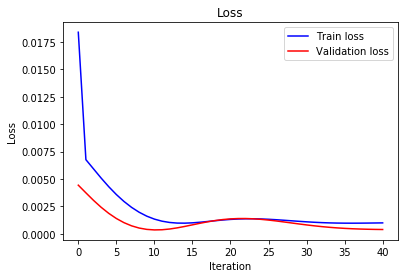

Iteration: 40, train loss: 0.0010, test loss: 0.0004


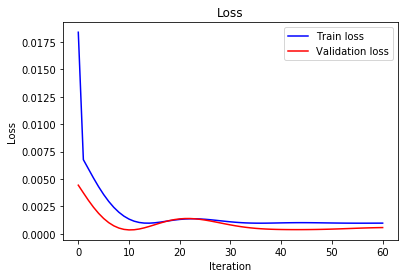

Iteration: 60, train loss: 0.0010, test loss: 0.0006


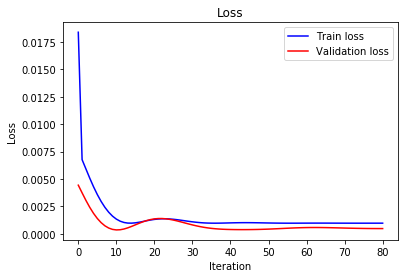

Iteration: 80, train loss: 0.0010, test loss: 0.0005


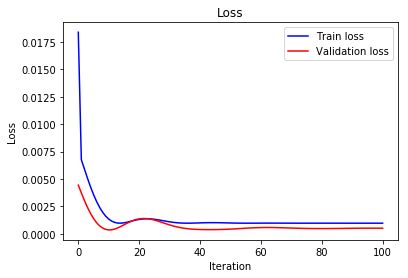

Iteration: 100, train loss: 0.0010, test loss: 0.0005


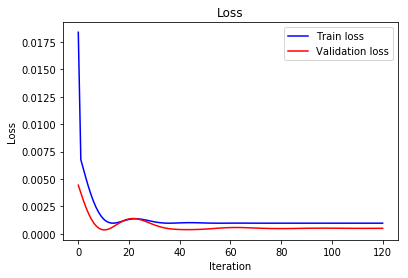

Iteration: 120, train loss: 0.0010, test loss: 0.0005


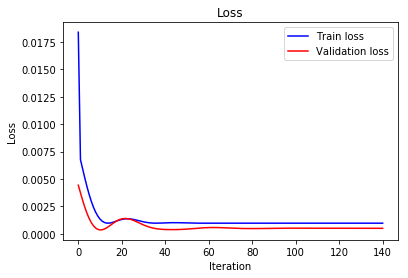

Iteration: 140, train loss: 0.0010, test loss: 0.0005


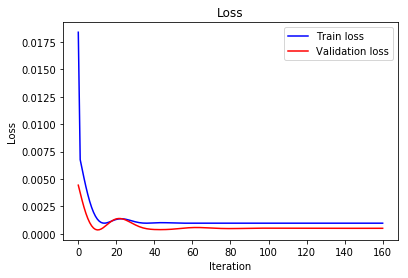

Iteration: 160, train loss: 0.0010, test loss: 0.0005


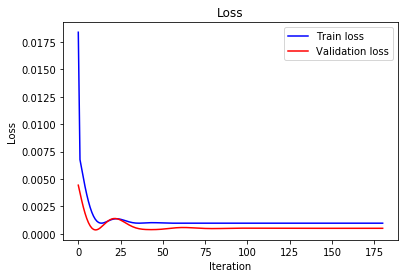

Iteration: 180, train loss: 0.0010, test loss: 0.0005


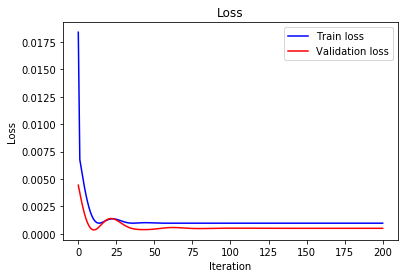

Iteration: 200, train loss: 0.0010, test loss: 0.0005


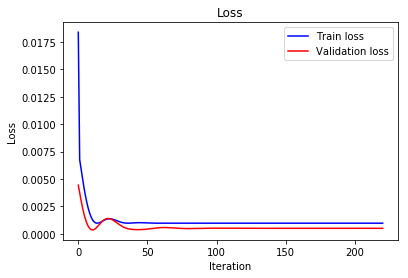

Iteration: 220, train loss: 0.0010, test loss: 0.0005


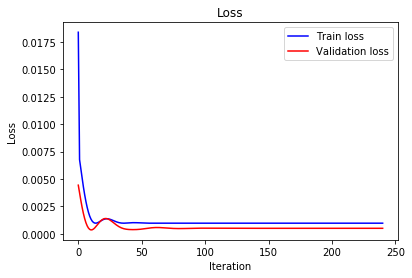

Iteration: 240, train loss: 0.0010, test loss: 0.0005


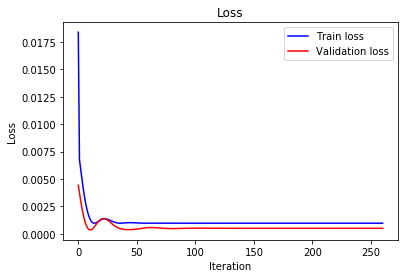

Iteration: 260, train loss: 0.0010, test loss: 0.0005


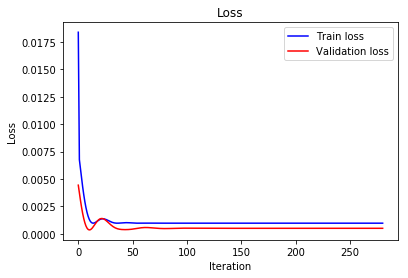

Iteration: 280, train loss: 0.0010, test loss: 0.0005


In [164]:
# Initialize a session
session = tf.Session()

# Create a new instance of the GRU model
gru = GRU(input_dimensions, hidden_size)

# Add an additional layer on top of each of the hidden state outputs
W_output = tf.Variable(tf.truncated_normal(
    dtype=tf.float64, shape=(hidden_size, 1), mean=0, stddev=0.01))
b_output = tf.Variable(tf.truncated_normal(
    dtype=tf.float64, shape=(1,), mean=0, stddev=0.01))
output = tf.map_fn(lambda h_t: tf.matmul(h_t, W_output) + b_output, gru.h_t)

# Create a placeholder for the expected output
expected_output = tf.placeholder(dtype=tf.float64, shape=(
    batch_size, time_size, 1), name='expected_output')

# Just use quadratic loss
loss = tf.reduce_sum(
    0.5 * tf.pow(output - expected_output, 2)) / float(batch_size)
# Use the Adam optimizer for training
train_step = tf.train.AdamOptimizer().minimize(loss)

# Initialize all the variables
init_variables = tf.global_variables_initializer()
session.run(init_variables)

# Initialize the losses
train_losses = []
validation_losses = []

# Perform all the iterations
for epoch in range(300):
    # Compute the losses
    _, train_loss = session.run([train_step, loss], feed_dict={
                                gru.input_layer: X_train, expected_output: Y_train})
    validation_loss = session.run(
        loss, feed_dict={gru.input_layer: X_test, expected_output: Y_test})

    # Log the losses
    train_losses += [train_loss]
    validation_losses += [validation_loss]

    # Display an update every 50 iterations
    if epoch % 20 == 0:
        plt.plot(train_losses, '-b', label='Train loss')
        plt.plot(validation_losses, '-r', label='Validation loss')
        plt.legend(loc=0)
        plt.title('Loss')
        plt.xlabel('Iteration')
        plt.ylabel('Loss')
        plt.show()
        print('Iteration: %d, train loss: %.4f, test loss: %.4f' %(epoch, train_loss, validation_loss))